# Cell type annotation with decoupler
**Authorship:** Adam Klie (last updated: 08/27/2023)<br>
***
**Description:** This notebook performs a cell type annotation analysis with decoupler

# Set-up

In [1]:
# Global Imports
import os
import sys
import yaml
import logging
import scanpy as sc
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3

In [2]:
# Inputs
input_h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2023_11_15/cellcommander/3-cyt/rna/annotate/annotate.h5ad"

In [3]:
# Outputs
results_dir = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/2023_11_27/decoupler"
out_analysis = "cell_type_annotation"
out_dir = os.path.join(results_dir, out_analysis)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [4]:
# Method params
annotation_resource = "PanglaoDB"
normalize_data = True
method = "ora"

In [5]:
# Make and log a yaml file with the parameters
data_params = {
    "input_h5ad_path": input_h5ad_path,
    "out_dir": out_dir,
}
decoupler_params = {
    "annotation_resource": annotation_resource,
    "normalize_data": normalize_data,
    "method": method,
}
version_params = {
    "Python": sys.version[:5],
    "scanpy": sc.__version__,
    "decoupler": dc.__version__,
}
params = {"data": data_params, "run": decoupler_params, "versions": version_params}
if not os.path.exists(os.path.join(out_dir, "cell_type_annotation_params.yaml")):
    with open(os.path.join(out_dir, "cell_type_annotation_params.yaml"), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

params.yaml already exists, will not overwrite


# Load data

In [6]:
# The data to load in is a scanpy object
adata = sc.read_h5ad(input_h5ad_path)
adata

AnnData object with n_obs × n_vars = 36986 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fra

# Marker genes

In [7]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.0,0.00439422,True,0.00331126,0.0204803,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.00503937,True,0.903226,0.0124084,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.0,0.00823306,True,0.225806,0.0137585,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


In [8]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True') & (markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
5,KLK1,True,Principal cells,Mesoderm,True,0.0,0.00814536,True,0.285714,0.0140583,9606,Kidney,0.013
6,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
7,KLK1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.0,0.00820189,True,1.0,0.0129136,9606,Immune system,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


In [9]:
# Save the markers that were actually used
markers.to_csv(os.path.join(out_dir, "markers_used.tsv"), sep="\t")

# Preprocess data

In [10]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 6503 genes that are detected in less than 3 cells


In [11]:
if normalize_data:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata

normalizing counts per cell


    finished (0:00:00)


# Run enrichment for markers

In [12]:
# Run ORA on top 5% of genes in each cell
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    use_raw=True,
    verbose=True
)

Running ora on mat with 36986 samples and 30098 targets for 150 sources.


100%|██████████| 36986/36986 [02:29<00:00, 247.15it/s]


In [13]:
# Check the results
adata.obsm['ora_estimate'].head()

source,Acinar cells,Adipocyte progenitor cells,Adipocytes,Adrenergic neurons,Airway epithelial cells,Airway goblet cells,Alpha cells,Alveolar macrophages,Anterior pituitary gland cells,Astrocytes,...,T regulatory cells,Tanycytes,Taste receptor cells,Thymocytes,Trichocytes,Trigeminal neurons,Trophoblast cells,Trophoblast progenitor cells,Tuft cells,Urothelial cells
dm31a#AAACAGCCAGCACGTT-1,0.195357,-0.0,0.263986,0.332307,-0.000000,0.296268,1.114838,1.513601,0.931761,0.023918,...,0.238700,0.093266,0.372456,-0.000000,-0.000000,-0.0,-0.000000,-0.0,-0.00000,-0.000000
dm31a#AAACAGCCATAAACCT-1,0.195357,-0.0,1.697959,0.332307,-0.000000,0.296268,1.114838,1.513601,0.931761,0.076066,...,0.702286,-0.000000,-0.000000,0.101825,-0.000000,-0.0,-0.000000,-0.0,-0.00000,-0.000000
dm31a#AAACAGCCATAGCGGA-1,0.015234,-0.0,0.080317,0.332307,-0.000000,0.296268,0.745949,0.570708,0.332307,0.076066,...,-0.000000,0.093266,-0.000000,-0.000000,0.679442,-0.0,0.570708,-0.0,-0.00000,0.265409
dm31a#AAACAGCCATGGTTAT-1,-0.000000,-0.0,0.011824,-0.000000,0.570708,-0.000000,2.052001,-0.000000,0.332307,0.076066,...,-0.000000,0.093266,0.111274,0.101825,-0.000000,-0.0,-0.000000,-0.0,0.04734,-0.000000
dm31a#AAACATGCAATTAGCT-1,-0.000000,-0.0,0.002733,0.332307,0.570708,-0.000000,1.114838,-0.000000,-0.000000,0.003964,...,0.238700,0.322270,0.372456,-0.000000,-0.000000,-0.0,-0.000000,-0.0,-0.00000,-0.000000


# Vizualize the results on the dimensionality reduction

In [14]:
# Basically just pulls out the above obsm into a new AnnDatas.X and copies the rest of it
acts = dc.get_acts(adata, obsm_key='ora_estimate')

In [15]:
# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

In [16]:
# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 36986 × 150
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fragm

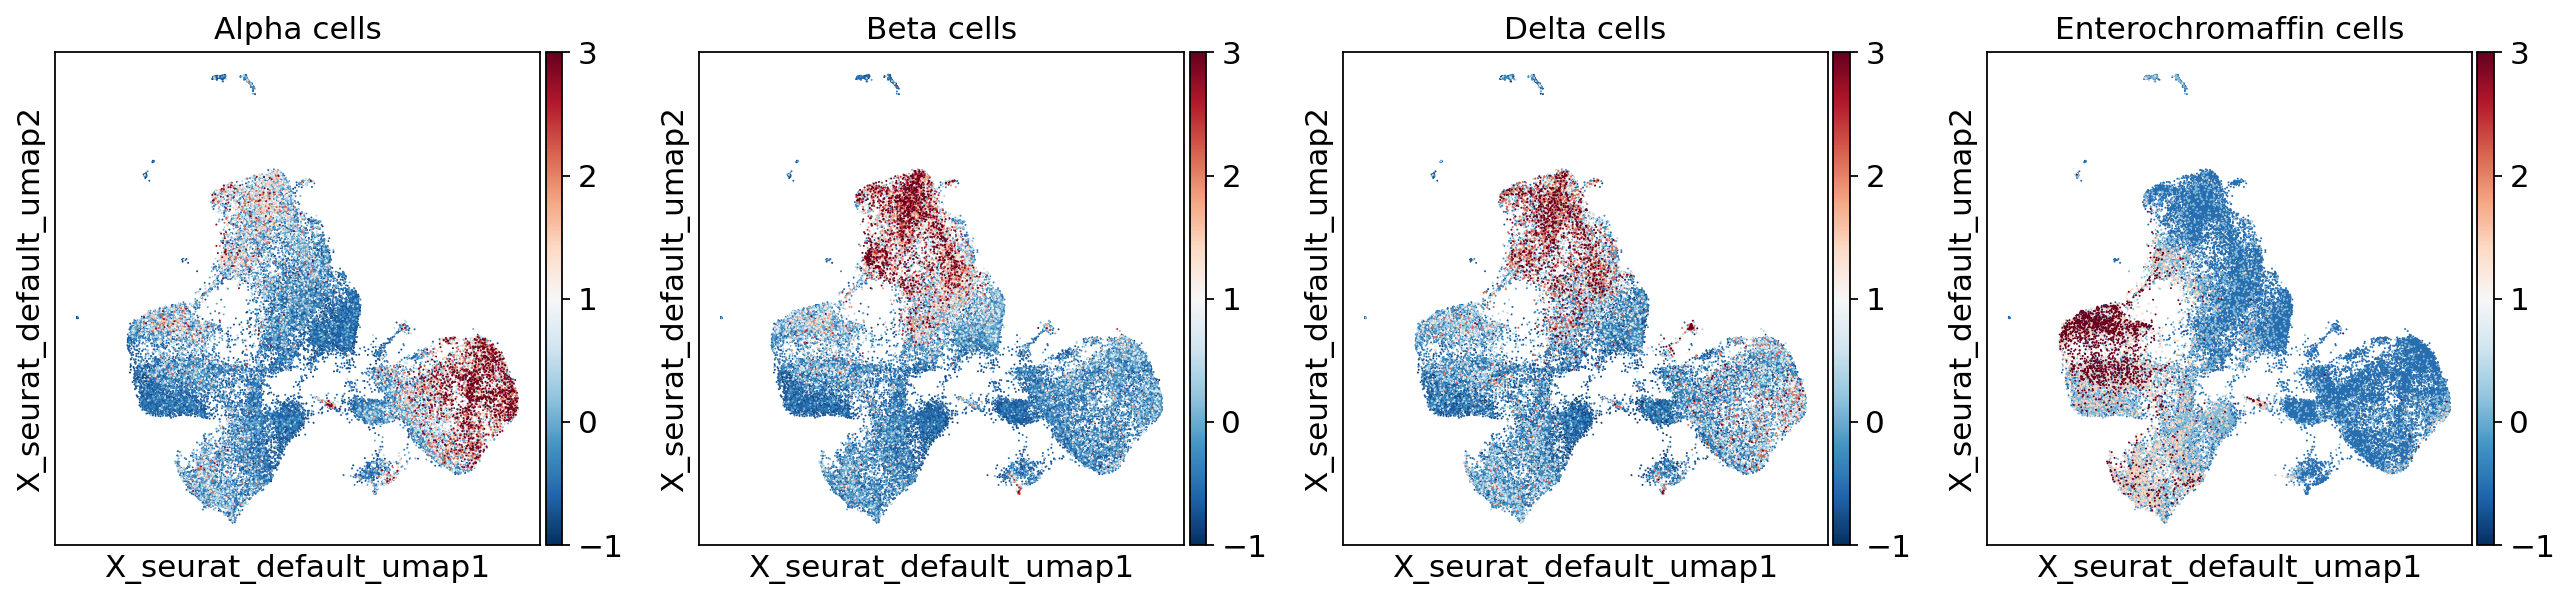

In [17]:
# Plot a few familiar cell types
with plt.rc_context():
    sc.pl.embedding(acts, basis="X_seurat_default_umap", color=['Alpha cells', 'Beta cells', 'Delta cells', 'Enterochromaffin cells'], cmap='RdBu_r', vmin=-1, vmax=3, show=False)
    plt.savefig(os.path.join(out_dir, "selected_cell_type_annotation_umap.png"))
    plt.show()
    plt.close()


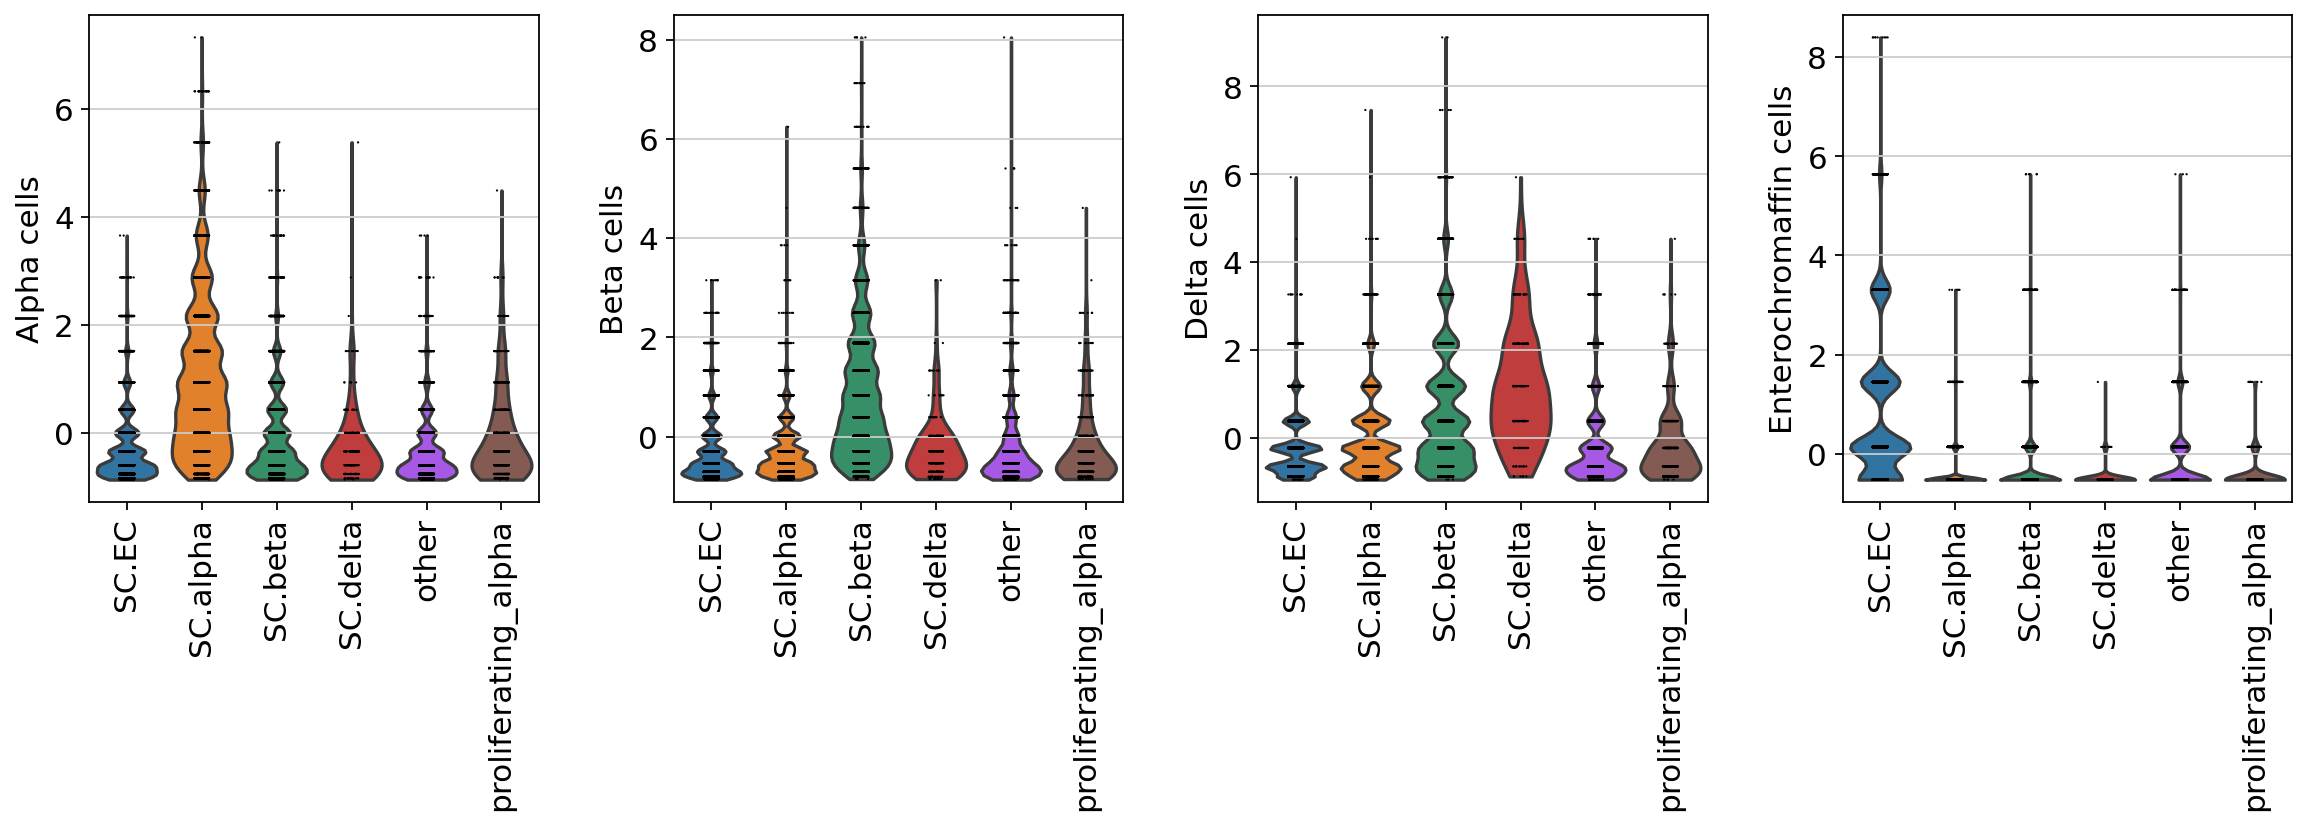

In [18]:
# Plot the violin plots
with plt.rc_context():
    sc.pl.violin(acts, keys=['Alpha cells', 'Beta cells', 'Delta cells', 'Enterochromaffin cells'], groupby='integrated_manual_cellid_annotation', multi_panel=True, rotation=90, show=False)
    plt.savefig(os.path.join(out_dir, "selected_cell_type_annotation_violin.png"))
    plt.show()
    plt.close()

# Annotation
We can next find the statistically significant annotations for pre-defined groupings of interest

In [19]:
# Does just that
df = dc.rank_sources_groups(acts, groupby='integrated_manual_cellid_annotation', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,SC.EC,rest,Enterochromaffin cells,82.401979,1.077744,0.000000e+00,0.000000e+00
1,SC.EC,rest,Pinealocytes,45.143033,0.617719,0.000000e+00,0.000000e+00
2,SC.EC,rest,Crypt cells,32.803624,0.451833,6.856526e-230,6.427993e-229
3,SC.EC,rest,Chromaffin cells,26.502581,0.350747,1.768099e-152,1.395868e-151
4,SC.EC,rest,Natural killer T cells,26.158682,0.338616,9.921263e-149,7.440947e-148
...,...,...,...,...,...,...,...
895,proliferating_alpha,rest,Serotonergic neurons,-4.502976,-0.258484,7.536069e-06,1.174066e-04
896,proliferating_alpha,rest,Adipocytes,-4.646699,-0.268924,3.846098e-06,7.211433e-05
897,proliferating_alpha,rest,Enteroendocrine cells,-5.788470,-0.328292,9.693522e-09,2.423380e-07
898,proliferating_alpha,rest,Pinealocytes,-6.117147,-0.316242,1.501167e-09,4.503501e-08


In [20]:
# Save the annotation results
df.to_csv(os.path.join(out_dir, "cell_type_annotation_by_groups.tsv"), sep="\t")

In [21]:
# We can grab a dictionary of the top X for each group
n_ctypes = 5
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'SC.EC': ['Enterochromaffin cells',
  'Pinealocytes',
  'Crypt cells',
  'Chromaffin cells',
  'Natural killer T cells'],
 'SC.alpha': ['Alpha cells',
  'B cells naive',
  'Leydig cells',
  'Podocytes',
  'Interneurons'],
 'SC.beta': ['Beta cells',
  'Delta cells',
  'Choroid plexus cells',
  'Parathyroid chief cells',
  'Retinal ganglion cells'],
 'SC.delta': ['Neuroendocrine cells',
  'Delta cells',
  'Interneurons',
  'GABAergic neurons',
  'Mesothelial cells'],
 'other': ['Alveolar macrophages',
  'Goblet cells',
  'Acinar cells',
  'Foveolar cells',
  'Enteric glia cells'],
 'proliferating_alpha': ['Cholinergic neurons',
  'Germ cells',
  'Gamma delta T cells',
  'Erythroblasts',
  'Granulosa cells']}

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50


    finished (0:00:04)
Storing dendrogram info using `.uns['dendrogram_integrated_manual_cellid_annotation']`


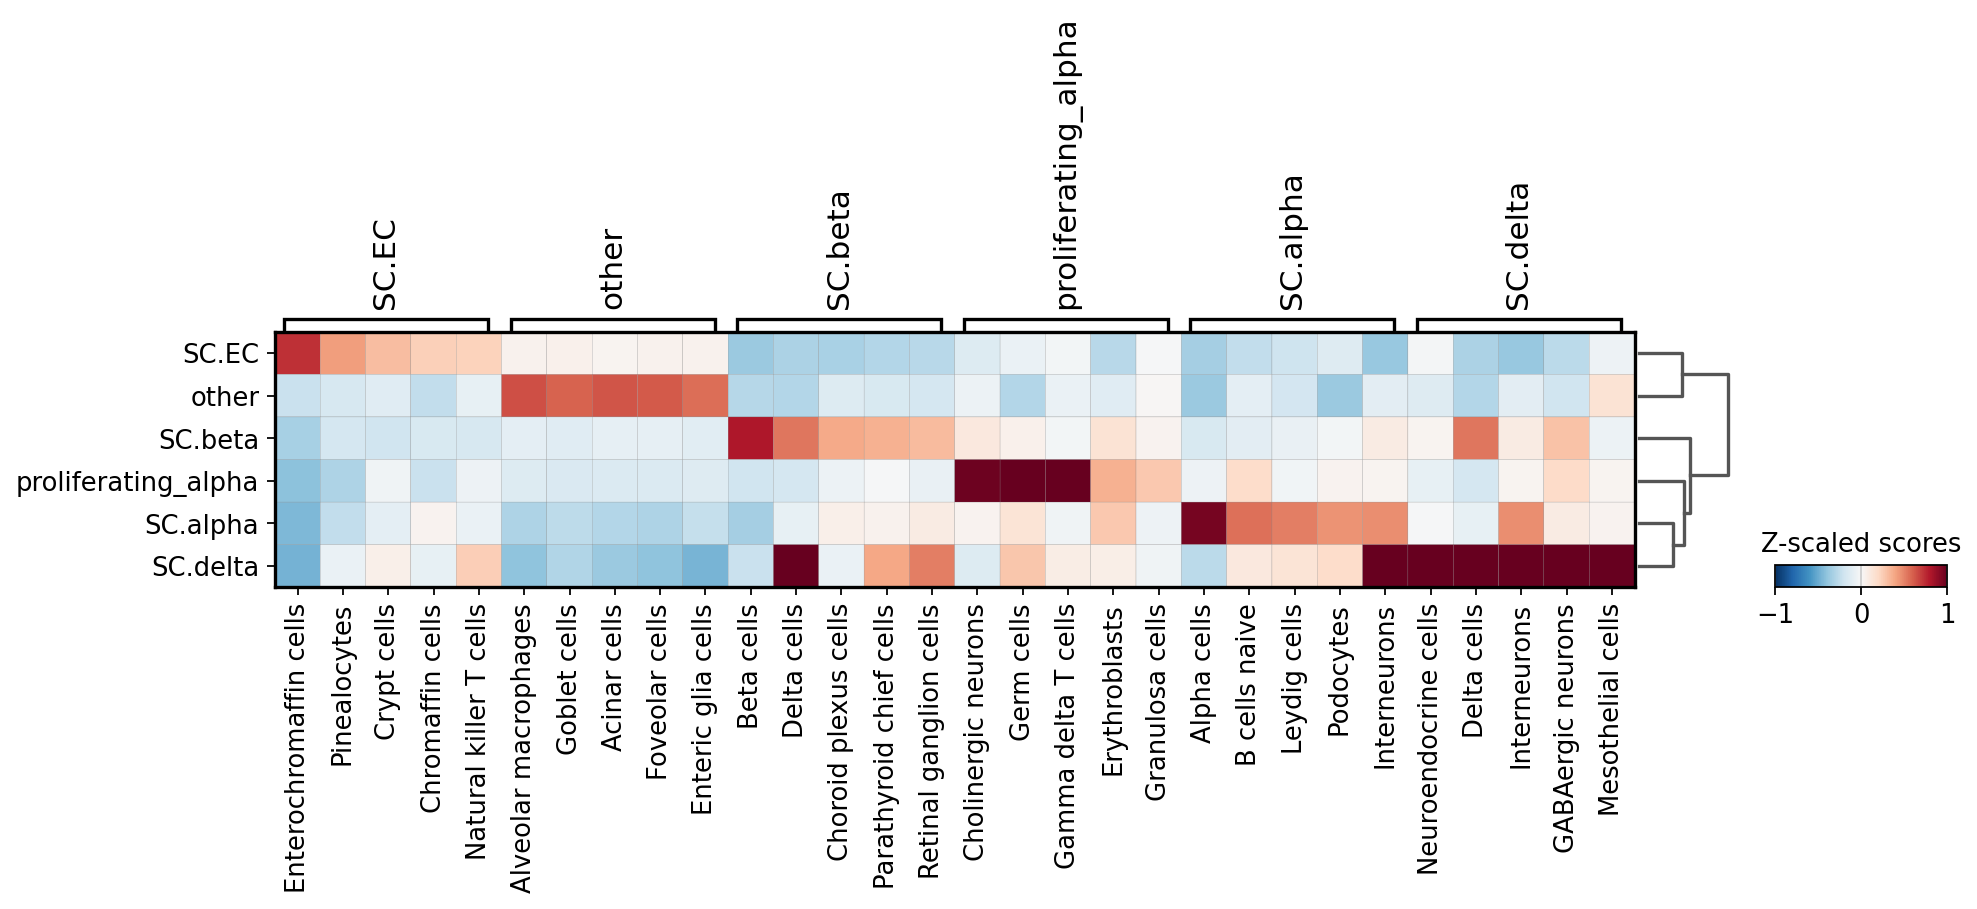

In [22]:
# And plot that as a matrixplot
with plt.rc_context():
    sc.pl.matrixplot(
        acts, 
        ctypes_dict, 
        'integrated_manual_cellid_annotation', 
        dendrogram=True,
        colorbar_title='Z-scaled scores', 
        vmin=-1, 
        vmax=1, 
        cmap='RdBu_r',
        show=False
    )
    plt.savefig(os.path.join(out_dir, f"{n_ctypes}_cell_type_annotation_matrixplot.png"))
    plt.show()

# DONE!

---